In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time
from PIL import Image

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components="mle")

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 3
RSZ = 96
MULT = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
torch_utils.seed_everything(947)

In [5]:
raw_train = pd.read_csv("./train.csv") 
raw_test = pd.read_csv("./test.csv")

In [6]:
raw_train.shape, raw_test.shape

((990, 194), (594, 193))

In [7]:
raw_test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [8]:
raw_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [9]:
train, valid = train_test_split(raw_train,test_size=0.1, stratify=raw_train.species, random_state=947)
train.shape, valid.shape

((891, 194), (99, 194))

In [10]:
pca.fit(train.drop(["id", "species"], axis=1))

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

le = LabelEncoder().fit(train.species)

train_labels = le.transform(train.species)
valid_labels = le.transform(valid.species)

train = train.drop(["species"], axis=1).values
valid = valid.drop(["species"], axis=1).values

In [12]:
class MyDataSet(Dataset):
    def __init__(self, X, y=None, tx=None, pca=None):
        self.X = X
        self.y = y
        self.tx = tx
        self.pca = pca
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        current_image_X = self.X[idx]
        
        image_path = "./images/"+str(int(current_image_X[0]))+".jpg"
        image = Image.open(image_path)
        
        if self.tx is not None:
            image = self.tx(image)
        
#         print(self.pca.transform(current_image_X[1:].reshape(1,-1)).shape)
        if self.y is not None:
            return (image, torch.Tensor(self.pca.transform(current_image_X[1:].reshape(1,-1)))), self.y[idx]
        
        return (image, torch.Tensor(self.pca.transform(current_image_X[1:].reshape(1,-1))))

In [13]:
train_transforms = txf.Compose([
    txf.Resize((RSZ, RSZ)),
    txf.RandomRotation(10),
    txf.RandomAffine(degrees=7, translate=(0.3,0.3), scale=(0.8, 1.2), shear=7,),
    txf.ToTensor(),
    txf.Normalize([0.5], [0.5])
])

In [14]:
test_transforms = txf.Compose([
    txf.Resize((RSZ, RSZ)),
    txf.ToTensor(),
    txf.Normalize([0.5], [0.5])
])

In [15]:
dataset_train = MyDataSet(train, train_labels, train_transforms, pca)
dataset_valid = MyDataSet(valid, valid_labels, test_transforms, pca)
dataset_test = MyDataSet(raw_test.values, tx=test_transforms, pca=pca)

In [16]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [17]:
class SimpleConvNet(nn.Module):
    def __init__(self, n_classes, drop_prob=0.3):
        super(SimpleConvNet, self).__init__()
        
        self.conv1 = torch_utils.CNNLayer(1, MULT*32)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32)
        
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*64)
        self.conv4 = torch_utils.CNNLayer(MULT*64, MULT*64)
        
        self.conv5 = torch_utils.CNNLayer(MULT*64, MULT*128)
        self.conv6 = torch_utils.CNNLayer(MULT*128, MULT*128)
        
        self.conv7 = torch_utils.CNNLayer(MULT*128, MULT*256)
        self.conv8 = torch_utils.CNNLayer(MULT*256, MULT*256)
        
        self.conv9 = torch_utils.CNNLayer(MULT*256, MULT*512)
        self.conv10 = torch_utils.CNNLayer(MULT*512, MULT*512)
        
        self.fc1 = torch_utils.FCLayer(191+(MULT*512*4*4), MULT*512)
        self.fc2 = torch_utils.FCLayer(MULT*512, MULT*512)
        self.fc3 = torch_utils.FCLayer(MULT*512, MULT*512)
        self.fc4 = torch_utils.FCLayer(MULT*512, MULT*512)
        
        self.out = torch_utils.FCLayer(MULT*512, n_classes)
        
        self.drop1d = nn.Dropout(p=drop_prob)
        self.maxpool = nn.MaxPool2d(2, 2) 
        self.drop = nn.Dropout2d(p=drop_prob)
    
    
    def forward(self, x):
        x, xx = x
        xx = xx.squeeze(dim=1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.maxpool(x)
        x = self.drop(x)
#         print(x.shape)
#         print(xx.shape)
        x = x.view(x.size(0), -1)
        x = torch.cat([xx, x], dim=1)
#         print(x.shape)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.out(x)
        
        return F.log_softmax(x, dim=1)

In [18]:
def train_classifier(model, optimizer, criterion, current_epoch, train_loader, device="cpu", print_interval=10, custom_txf=None, one_hot=False):
    model.train()
    model.to(device)
    
    train_correct = 0
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        len_data = len(data[0])
        len_dataset = len(train_loader.dataset)
        len_loader = len(train_loader)
        
        
        data, target = (data[0].to(device), data[1].to(device)), target.to(device)
        
        if custom_txf is not None:
            data, target = custom_txf(data, target)
        
        output = model(data)
        
        if not one_hot:
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            train_correct += pred.eq(target.view_as(pred)).sum().item()
        else:
            pred = output.data.max(1, keepdim=True)[1]
            train_correct += pred.eq(target.max(1, keepdim=True)[1].data.view_as(pred)).cpu().sum().numpy()
        
        loss = criterion(output, target)
        train_loss+= (loss.item() * len_data)
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % print_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.8f}%)]\tLoss: {:.8f}'.format(
                    current_epoch, batch_idx * len_data, len_dataset,100. * batch_idx / len_loader, loss.item()
                    )
                )
    ## This is training, so reduction = mean, i.e. loss.item() already gives the mean of the batch
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    print('Train Set: Average loss: {:.8f}, Accuracy: {}/{} ({:.8f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset), train_accuracy
        )
    )
    
    return train_loss, train_accuracy
    
    
    
def test_classifier(model, criterion, device, test_loader, one_hot=False, tta=False):
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = (data[0].to(device), data[1].to(device)), target.to(device)
            if tta:
                batch_size, n_crops, c, h, w = data.size()
                data = data.view(-1, c, h, w)
                output = model(data)
                output = output.view(batch_size, n_crops, -1).mean(1)
            else:
                output = model(data)
            
            test_loss += criterion(output, target).item()  # sum up batch loss
            if not one_hot:
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                test_correct += pred.eq(target.view_as(pred)).sum().item()
            else:
                pred = output.data.max(1, keepdim=True)[1]
                test_correct += pred.eq(target.max(1, keepdim=True)[1].data.view_as(pred)).cpu().sum().numpy()


    ## validation/test, so reduction = "sum"
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * test_correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.8f}, Accuracy: {}/{} ({:.8f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),test_accuracy
        )
    )
    return test_loss, test_accuracy

In [19]:
class SQENet(nn.Module):
    ## Squeeze and excitation net
    def __init__(self, n_classes, drop_prob=0.3):
        super(SQENet, self).__init__()
        
        self.conv1 = torch_utils.CNNLayer(1, MULT*32, 5)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32, 5)
        
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*64,5)
        self.conv4 = torch_utils.CNNLayer(MULT*64, MULT*64,5)
        
        self.conv5 = torch_utils.CNNLayer(MULT*64, MULT*128)
        self.conv6 = torch_utils.CNNLayer(MULT*128, MULT*128)
        
        self.conv7 = torch_utils.CNNLayer(MULT*128, MULT*256)
        self.conv8 = torch_utils.CNNLayer(MULT*256, MULT*256)
        
        self.se3 = torch_utils.Sq_Ex_Block(in_ch=MULT*256,r=8)
        
        self.fc1 = torch_utils.FCLayer(191+(MULT*256*8*8), 256)
        self.fc2 = torch_utils.FCLayer(256, n_classes)
        
        
        self.maxpool = nn.MaxPool2d(2, 2) 
        self.drop = nn.Dropout2d(p=drop_prob)
    
    
    def forward(self, x):
        x, xx = x
        xx = xx.squeeze(dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv7(x)
        x = self.conv8(x)
        
        x = self.se3(x)
        
        x = self.maxpool(x)
        x = self.drop(x)
        
#         print(xx.shape)
#         print(x.shape)
        x = x.view(x.size(0), -1)
        x = torch.cat([xx, x], dim=1)
#         print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [71]:
class AMNet(nn.Module):
    ## Squeeze and excitation net
    def __init__(self, n_classes, drop_prob=0.3):
        super(AMNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 32, 5, padding=2),
            nn.BatchNorm2d(32),
#             torch_utils.Sq_Ex_Block(in_ch=32,r=8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
#             torch_utils.Sq_Ex_Block(in_ch=64,r=8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.out = nn.Sequential(
            nn.Linear((12*12*64)+191, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes),
            nn.LogSoftmax(dim=1)
        )
    
    
    def forward(self, x):
        x, xx = x
        xx = xx.squeeze(dim=1)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([xx, x], dim=1)
        
        return self.out(x)

In [72]:
model = AMNet(len(le.classes_)).to(device)
n_epochs = 500
criterion = nn.NLLLoss()
optimizer = torch_utils.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, n_epochs//4, gamma=0.75)

In [73]:
import time

training_history = pd.DataFrame()

for epoch in range(n_epochs):
    curt = time.time()
    torch_utils.clear_cuda()
    
    print("Learning Rate: {}".format(torch_utils.get_lr(optimizer)))
    
    train_loss, train_acc = train_classifier(model,optimizer,criterion,1+epoch,train_loader,
                                 device=device, print_interval=10)
    valid_loss, valid_acc = test_classifier(model, nn.NLLLoss(reduction="sum"), device, valid_loader)
    
    scheduler.step()
    
    training_history.loc[epoch, "train_loss"] = train_loss
    training_history.loc[epoch, "valid_loss"] = valid_loss
    training_history.loc[epoch, "train_accuracy"] = train_acc
    training_history.loc[epoch, "valid_accuracy"] = valid_acc
    print("Epoch {} time: {} seconds\n\n".format(epoch+1, time.time()-curt))

Learning Rate: 0.01
Train Epoch: 1 [0/891 (0.00000000%)]	Loss: 5.03411865
Train Epoch: 1 [320/891 (35.71428571%)]	Loss: 5.09584045
Train Epoch: 1 [640/891 (71.42857143%)]	Loss: 4.75775957
Train Set: Average loss: 4.86870348, Accuracy: 8/891 (0.89786756%)

Test set: Average loss: 4.54028101, Accuracy: 1/99 (1.01010101%)

Epoch 1 time: 1.0051159858703613 seconds


Learning Rate: 0.01
Train Epoch: 2 [0/891 (0.00000000%)]	Loss: 4.62733459
Train Epoch: 2 [320/891 (35.71428571%)]	Loss: 4.68065548
Train Epoch: 2 [640/891 (71.42857143%)]	Loss: 4.95789289
Train Set: Average loss: 4.79036066, Accuracy: 17/891 (1.90796857%)

Test set: Average loss: 4.39998027, Accuracy: 3/99 (3.03030303%)

Epoch 2 time: 1.0028033256530762 seconds


Learning Rate: 0.01
Train Epoch: 3 [0/891 (0.00000000%)]	Loss: 4.90903568
Train Epoch: 3 [320/891 (35.71428571%)]	Loss: 4.64941740
Train Epoch: 3 [640/891 (71.42857143%)]	Loss: 4.39744854
Train Set: Average loss: 4.61015513, Accuracy: 18/891 (2.02020202%)

Test set: Av

Train Epoch: 23 [640/891 (71.42857143%)]	Loss: 3.54794312
Train Set: Average loss: 3.57963038, Accuracy: 76/891 (8.52974186%)

Test set: Average loss: 3.69693558, Accuracy: 8/99 (8.08080808%)

Epoch 23 time: 1.0375092029571533 seconds


Learning Rate: 0.01
Train Epoch: 24 [0/891 (0.00000000%)]	Loss: 3.46544290
Train Epoch: 24 [320/891 (35.71428571%)]	Loss: 3.84474349
Train Epoch: 24 [640/891 (71.42857143%)]	Loss: 3.90288472
Train Set: Average loss: 3.70425775, Accuracy: 70/891 (7.85634119%)

Test set: Average loss: 3.18690763, Accuracy: 11/99 (11.11111111%)

Epoch 24 time: 1.0370404720306396 seconds


Learning Rate: 0.01
Train Epoch: 25 [0/891 (0.00000000%)]	Loss: 3.43413568
Train Epoch: 25 [320/891 (35.71428571%)]	Loss: 3.48782229
Train Epoch: 25 [640/891 (71.42857143%)]	Loss: 3.53428125
Train Set: Average loss: 3.57431205, Accuracy: 73/891 (8.19304153%)

Test set: Average loss: 3.48197386, Accuracy: 10/99 (10.10101010%)

Epoch 25 time: 1.0589845180511475 seconds


Learning Rate: 0.01

Train Set: Average loss: 3.04259779, Accuracy: 140/891 (15.71268238%)

Test set: Average loss: 3.01576548, Accuracy: 15/99 (15.15151515%)

Epoch 45 time: 1.0174920558929443 seconds


Learning Rate: 0.01
Train Epoch: 46 [0/891 (0.00000000%)]	Loss: 3.22969437
Train Epoch: 46 [320/891 (35.71428571%)]	Loss: 2.95890427
Train Epoch: 46 [640/891 (71.42857143%)]	Loss: 2.68653774
Train Set: Average loss: 3.03869369, Accuracy: 142/891 (15.93714927%)

Test set: Average loss: 2.50843364, Accuracy: 25/99 (25.25252525%)

Epoch 46 time: 1.0085420608520508 seconds


Learning Rate: 0.01
Train Epoch: 47 [0/891 (0.00000000%)]	Loss: 3.11671758
Train Epoch: 47 [320/891 (35.71428571%)]	Loss: 3.16825342
Train Epoch: 47 [640/891 (71.42857143%)]	Loss: 2.77821183
Train Set: Average loss: 2.96895524, Accuracy: 161/891 (18.06958474%)

Test set: Average loss: 2.27510684, Accuracy: 40/99 (40.40404040%)

Epoch 47 time: 1.0027339458465576 seconds


Learning Rate: 0.01
Train Epoch: 48 [0/891 (0.00000000%)]	Loss: 2.940


Test set: Average loss: 0.85586640, Accuracy: 70/99 (70.70707071%)

Epoch 67 time: 1.0428221225738525 seconds


Learning Rate: 0.01
Train Epoch: 68 [0/891 (0.00000000%)]	Loss: 1.17774224
Train Epoch: 68 [320/891 (35.71428571%)]	Loss: 1.29494762
Train Epoch: 68 [640/891 (71.42857143%)]	Loss: 1.33954275
Train Set: Average loss: 1.19779849, Accuracy: 525/891 (58.92255892%)

Test set: Average loss: 0.80736027, Accuracy: 74/99 (74.74747475%)

Epoch 68 time: 1.0020792484283447 seconds


Learning Rate: 0.01
Train Epoch: 69 [0/891 (0.00000000%)]	Loss: 0.98952746
Train Epoch: 69 [320/891 (35.71428571%)]	Loss: 1.29932499
Train Epoch: 69 [640/891 (71.42857143%)]	Loss: 0.71988291
Train Set: Average loss: 1.26714297, Accuracy: 513/891 (57.57575758%)

Test set: Average loss: 0.82911779, Accuracy: 67/99 (67.67676768%)

Epoch 69 time: 1.0095868110656738 seconds


Learning Rate: 0.01
Train Epoch: 70 [0/891 (0.00000000%)]	Loss: 1.40966296
Train Epoch: 70 [320/891 (35.71428571%)]	Loss: 1.42597091
Train 


Test set: Average loss: 0.59977477, Accuracy: 80/99 (80.80808081%)

Epoch 89 time: 1.0482041835784912 seconds


Learning Rate: 0.01
Train Epoch: 90 [0/891 (0.00000000%)]	Loss: 0.72461832
Train Epoch: 90 [320/891 (35.71428571%)]	Loss: 1.17763424
Train Epoch: 90 [640/891 (71.42857143%)]	Loss: 0.69614315
Train Set: Average loss: 0.75461946, Accuracy: 673/891 (75.53310887%)

Test set: Average loss: 0.61448493, Accuracy: 76/99 (76.76767677%)

Epoch 90 time: 0.9698917865753174 seconds


Learning Rate: 0.01
Train Epoch: 91 [0/891 (0.00000000%)]	Loss: 0.94621676
Train Epoch: 91 [320/891 (35.71428571%)]	Loss: 1.04746771
Train Epoch: 91 [640/891 (71.42857143%)]	Loss: 0.99865252
Train Set: Average loss: 0.78891680, Accuracy: 651/891 (73.06397306%)

Test set: Average loss: 0.56320274, Accuracy: 80/99 (80.80808081%)

Epoch 91 time: 0.9941420555114746 seconds


Learning Rate: 0.01
Train Epoch: 92 [0/891 (0.00000000%)]	Loss: 0.57777053
Train Epoch: 92 [320/891 (35.71428571%)]	Loss: 0.76403850
Train 

Train Set: Average loss: 0.42363032, Accuracy: 756/891 (84.84848485%)

Test set: Average loss: 0.42320634, Accuracy: 86/99 (86.86868687%)

Epoch 111 time: 1.028745174407959 seconds


Learning Rate: 0.01
Train Epoch: 112 [0/891 (0.00000000%)]	Loss: 0.77153659
Train Epoch: 112 [320/891 (35.71428571%)]	Loss: 0.37965962
Train Epoch: 112 [640/891 (71.42857143%)]	Loss: 0.56503701
Train Set: Average loss: 0.47693790, Accuracy: 743/891 (83.38945006%)

Test set: Average loss: 0.29029279, Accuracy: 91/99 (91.91919192%)

Epoch 112 time: 1.0091452598571777 seconds


Learning Rate: 0.01
Train Epoch: 113 [0/891 (0.00000000%)]	Loss: 0.25801417
Train Epoch: 113 [320/891 (35.71428571%)]	Loss: 0.37473190
Train Epoch: 113 [640/891 (71.42857143%)]	Loss: 0.70667279
Train Set: Average loss: 0.38770716, Accuracy: 774/891 (86.86868687%)

Test set: Average loss: 0.39622101, Accuracy: 83/99 (83.83838384%)

Epoch 113 time: 1.0341110229492188 seconds


Learning Rate: 0.01
Train Epoch: 114 [0/891 (0.00000000%)]	Lo

Train Epoch: 133 [320/891 (35.71428571%)]	Loss: 0.16434759
Train Epoch: 133 [640/891 (71.42857143%)]	Loss: 0.49228629
Train Set: Average loss: 0.28509297, Accuracy: 797/891 (89.45005612%)

Test set: Average loss: 0.28693322, Accuracy: 88/99 (88.88888889%)

Epoch 133 time: 1.031968116760254 seconds


Learning Rate: 0.0075
Train Epoch: 134 [0/891 (0.00000000%)]	Loss: 0.33629259
Train Epoch: 134 [320/891 (35.71428571%)]	Loss: 0.27486169
Train Epoch: 134 [640/891 (71.42857143%)]	Loss: 0.30309629
Train Set: Average loss: 0.29549301, Accuracy: 800/891 (89.78675645%)

Test set: Average loss: 0.30730179, Accuracy: 89/99 (89.89898990%)

Epoch 134 time: 1.0592236518859863 seconds


Learning Rate: 0.0075
Train Epoch: 135 [0/891 (0.00000000%)]	Loss: 0.47018912
Train Epoch: 135 [320/891 (35.71428571%)]	Loss: 0.22357571
Train Epoch: 135 [640/891 (71.42857143%)]	Loss: 0.34018004
Train Set: Average loss: 0.25342262, Accuracy: 822/891 (92.25589226%)

Test set: Average loss: 0.32534060, Accuracy: 88/99 

Train Epoch: 155 [0/891 (0.00000000%)]	Loss: 0.20395330
Train Epoch: 155 [320/891 (35.71428571%)]	Loss: 0.13839722
Train Epoch: 155 [640/891 (71.42857143%)]	Loss: 0.27533990
Train Set: Average loss: 0.19699175, Accuracy: 832/891 (93.37822671%)

Test set: Average loss: 0.24456056, Accuracy: 92/99 (92.92929293%)

Epoch 155 time: 0.9979829788208008 seconds


Learning Rate: 0.0075
Train Epoch: 156 [0/891 (0.00000000%)]	Loss: 0.27115822
Train Epoch: 156 [320/891 (35.71428571%)]	Loss: 0.12764829
Train Epoch: 156 [640/891 (71.42857143%)]	Loss: 0.15582925
Train Set: Average loss: 0.26060779, Accuracy: 809/891 (90.79685746%)

Test set: Average loss: 0.28698573, Accuracy: 91/99 (91.91919192%)

Epoch 156 time: 0.9826452732086182 seconds


Learning Rate: 0.0075
Train Epoch: 157 [0/891 (0.00000000%)]	Loss: 0.07444447
Train Epoch: 157 [320/891 (35.71428571%)]	Loss: 0.24825823
Train Epoch: 157 [640/891 (71.42857143%)]	Loss: 0.11353761
Train Set: Average loss: 0.21733265, Accuracy: 829/891 (93.0415263


Test set: Average loss: 0.32699575, Accuracy: 91/99 (91.91919192%)

Epoch 176 time: 1.0119602680206299 seconds


Learning Rate: 0.0075
Train Epoch: 177 [0/891 (0.00000000%)]	Loss: 0.09983659
Train Epoch: 177 [320/891 (35.71428571%)]	Loss: 0.08706081
Train Epoch: 177 [640/891 (71.42857143%)]	Loss: 0.18306294
Train Set: Average loss: 0.19716654, Accuracy: 833/891 (93.49046016%)

Test set: Average loss: 0.35901158, Accuracy: 89/99 (89.89898990%)

Epoch 177 time: 1.0177114009857178 seconds


Learning Rate: 0.0075
Train Epoch: 178 [0/891 (0.00000000%)]	Loss: 0.16733980
Train Epoch: 178 [320/891 (35.71428571%)]	Loss: 0.13176692
Train Epoch: 178 [640/891 (71.42857143%)]	Loss: 0.31892163
Train Set: Average loss: 0.23529341, Accuracy: 827/891 (92.81705948%)

Test set: Average loss: 0.20436730, Accuracy: 94/99 (94.94949495%)

Epoch 178 time: 0.9946529865264893 seconds


Learning Rate: 0.0075
Train Epoch: 179 [0/891 (0.00000000%)]	Loss: 0.06914565
Train Epoch: 179 [320/891 (35.71428571%)]	Loss: 

Train Epoch: 198 [640/891 (71.42857143%)]	Loss: 0.55559337
Train Set: Average loss: 0.22803597, Accuracy: 822/891 (92.25589226%)

Test set: Average loss: 0.39269116, Accuracy: 90/99 (90.90909091%)

Epoch 198 time: 1.0237312316894531 seconds


Learning Rate: 0.0075
Train Epoch: 199 [0/891 (0.00000000%)]	Loss: 0.54014546
Train Epoch: 199 [320/891 (35.71428571%)]	Loss: 0.14117661
Train Epoch: 199 [640/891 (71.42857143%)]	Loss: 0.14651072
Train Set: Average loss: 0.21819508, Accuracy: 827/891 (92.81705948%)

Test set: Average loss: 0.36597735, Accuracy: 90/99 (90.90909091%)

Epoch 199 time: 0.9948790073394775 seconds


Learning Rate: 0.0075
Train Epoch: 200 [0/891 (0.00000000%)]	Loss: 0.10285705
Train Epoch: 200 [320/891 (35.71428571%)]	Loss: 0.07665014
Train Epoch: 200 [640/891 (71.42857143%)]	Loss: 0.46933070
Train Set: Average loss: 0.16894165, Accuracy: 837/891 (93.93939394%)

Test set: Average loss: 0.31393328, Accuracy: 93/99 (93.93939394%)

Epoch 200 time: 1.0137341022491455 seconds

Train Epoch: 220 [0/891 (0.00000000%)]	Loss: 0.04600012
Train Epoch: 220 [320/891 (35.71428571%)]	Loss: 0.18040186
Train Epoch: 220 [640/891 (71.42857143%)]	Loss: 0.10739914
Train Set: Average loss: 0.19602213, Accuracy: 837/891 (93.93939394%)

Test set: Average loss: 0.22145832, Accuracy: 92/99 (92.92929293%)

Epoch 220 time: 1.0125458240509033 seconds


Learning Rate: 0.0075
Train Epoch: 221 [0/891 (0.00000000%)]	Loss: 0.19757754
Train Epoch: 221 [320/891 (35.71428571%)]	Loss: 0.16402841
Train Epoch: 221 [640/891 (71.42857143%)]	Loss: 0.22960103
Train Set: Average loss: 0.22106212, Accuracy: 820/891 (92.03142536%)

Test set: Average loss: 0.29604752, Accuracy: 92/99 (92.92929293%)

Epoch 221 time: 1.056227445602417 seconds


Learning Rate: 0.0075
Train Epoch: 222 [0/891 (0.00000000%)]	Loss: 0.38312396
Train Epoch: 222 [320/891 (35.71428571%)]	Loss: 0.22019333
Train Epoch: 222 [640/891 (71.42857143%)]	Loss: 0.15321529
Train Set: Average loss: 0.18827382, Accuracy: 831/891 (93.26599327


Test set: Average loss: 0.37419417, Accuracy: 88/99 (88.88888889%)

Epoch 241 time: 1.011678695678711 seconds


Learning Rate: 0.0075
Train Epoch: 242 [0/891 (0.00000000%)]	Loss: 0.14746594
Train Epoch: 242 [320/891 (35.71428571%)]	Loss: 0.03875464
Train Epoch: 242 [640/891 (71.42857143%)]	Loss: 0.27047896
Train Set: Average loss: 0.15448872, Accuracy: 843/891 (94.61279461%)

Test set: Average loss: 0.37224708, Accuracy: 89/99 (89.89898990%)

Epoch 242 time: 0.9987256526947021 seconds


Learning Rate: 0.0075
Train Epoch: 243 [0/891 (0.00000000%)]	Loss: 0.05509371
Train Epoch: 243 [320/891 (35.71428571%)]	Loss: 0.28373480
Train Epoch: 243 [640/891 (71.42857143%)]	Loss: 0.20098639
Train Set: Average loss: 0.15459278, Accuracy: 850/891 (95.39842873%)

Test set: Average loss: 0.26730006, Accuracy: 90/99 (90.90909091%)

Epoch 243 time: 1.0149829387664795 seconds


Learning Rate: 0.0075
Train Epoch: 244 [0/891 (0.00000000%)]	Loss: 0.15675223
Train Epoch: 244 [320/891 (35.71428571%)]	Loss: 0

Train Epoch: 263 [640/891 (71.42857143%)]	Loss: 0.00396711
Train Set: Average loss: 0.09209584, Accuracy: 865/891 (97.08193042%)

Test set: Average loss: 0.28501830, Accuracy: 93/99 (93.93939394%)

Epoch 263 time: 0.9986639022827148 seconds


Learning Rate: 0.005625
Train Epoch: 264 [0/891 (0.00000000%)]	Loss: 0.53958398
Train Epoch: 264 [320/891 (35.71428571%)]	Loss: 0.03278393
Train Epoch: 264 [640/891 (71.42857143%)]	Loss: 0.12490588
Train Set: Average loss: 0.13152060, Accuracy: 851/891 (95.51066218%)

Test set: Average loss: 0.30324314, Accuracy: 92/99 (92.92929293%)

Epoch 264 time: 1.054893970489502 seconds


Learning Rate: 0.005625
Train Epoch: 265 [0/891 (0.00000000%)]	Loss: 0.06538659
Train Epoch: 265 [320/891 (35.71428571%)]	Loss: 0.23729694
Train Epoch: 265 [640/891 (71.42857143%)]	Loss: 0.01237386
Train Set: Average loss: 0.10081642, Accuracy: 857/891 (96.18406285%)

Test set: Average loss: 0.30559108, Accuracy: 93/99 (93.93939394%)

Epoch 265 time: 1.0268614292144775 seco

Train Epoch: 285 [0/891 (0.00000000%)]	Loss: 0.17131442
Train Epoch: 285 [320/891 (35.71428571%)]	Loss: 0.03710020
Train Epoch: 285 [640/891 (71.42857143%)]	Loss: 0.04919356
Train Set: Average loss: 0.10429197, Accuracy: 856/891 (96.07182941%)

Test set: Average loss: 0.23536374, Accuracy: 92/99 (92.92929293%)

Epoch 285 time: 0.9862387180328369 seconds


Learning Rate: 0.005625
Train Epoch: 286 [0/891 (0.00000000%)]	Loss: 0.20711273
Train Epoch: 286 [320/891 (35.71428571%)]	Loss: 0.01340544
Train Epoch: 286 [640/891 (71.42857143%)]	Loss: 0.02008194
Train Set: Average loss: 0.10810256, Accuracy: 859/891 (96.40852974%)

Test set: Average loss: 0.26237497, Accuracy: 93/99 (93.93939394%)

Epoch 286 time: 1.0044384002685547 seconds


Learning Rate: 0.005625
Train Epoch: 287 [0/891 (0.00000000%)]	Loss: 0.02044520
Train Epoch: 287 [320/891 (35.71428571%)]	Loss: 0.05429852
Train Epoch: 287 [640/891 (71.42857143%)]	Loss: 0.04447472
Train Set: Average loss: 0.11479295, Accuracy: 861/891 (96.632


Test set: Average loss: 0.29468662, Accuracy: 92/99 (92.92929293%)

Epoch 306 time: 1.0169270038604736 seconds


Learning Rate: 0.005625
Train Epoch: 307 [0/891 (0.00000000%)]	Loss: 0.25687432
Train Epoch: 307 [320/891 (35.71428571%)]	Loss: 0.12668604
Train Epoch: 307 [640/891 (71.42857143%)]	Loss: 0.27217847
Train Set: Average loss: 0.11490615, Accuracy: 848/891 (95.17396184%)

Test set: Average loss: 0.27755485, Accuracy: 91/99 (91.91919192%)

Epoch 307 time: 1.0307197570800781 seconds


Learning Rate: 0.005625
Train Epoch: 308 [0/891 (0.00000000%)]	Loss: 0.04206210
Train Epoch: 308 [320/891 (35.71428571%)]	Loss: 0.08686560
Train Epoch: 308 [640/891 (71.42857143%)]	Loss: 0.11594230
Train Set: Average loss: 0.07421701, Accuracy: 865/891 (97.08193042%)

Test set: Average loss: 0.28594100, Accuracy: 91/99 (91.91919192%)

Epoch 308 time: 0.9840555191040039 seconds


Learning Rate: 0.005625
Train Epoch: 309 [0/891 (0.00000000%)]	Loss: 0.00940126
Train Epoch: 309 [320/891 (35.71428571%)]	

Train Epoch: 328 [320/891 (35.71428571%)]	Loss: 0.03447306
Train Epoch: 328 [640/891 (71.42857143%)]	Loss: 0.04998732
Train Set: Average loss: 0.11137620, Accuracy: 855/891 (95.95959596%)

Test set: Average loss: 0.28482587, Accuracy: 93/99 (93.93939394%)

Epoch 328 time: 1.061347246170044 seconds


Learning Rate: 0.005625
Train Epoch: 329 [0/891 (0.00000000%)]	Loss: 0.11488402
Train Epoch: 329 [320/891 (35.71428571%)]	Loss: 0.11992067
Train Epoch: 329 [640/891 (71.42857143%)]	Loss: 0.09703445
Train Set: Average loss: 0.12119232, Accuracy: 856/891 (96.07182941%)

Test set: Average loss: 0.27648928, Accuracy: 93/99 (93.93939394%)

Epoch 329 time: 1.10825514793396 seconds


Learning Rate: 0.005625
Train Epoch: 330 [0/891 (0.00000000%)]	Loss: 0.16073829
Train Epoch: 330 [320/891 (35.71428571%)]	Loss: 0.13947898
Train Epoch: 330 [640/891 (71.42857143%)]	Loss: 0.06170523
Train Set: Average loss: 0.12751732, Accuracy: 852/891 (95.62289562%)

Test set: Average loss: 0.29549834, Accuracy: 94/9


Test set: Average loss: 0.34100519, Accuracy: 92/99 (92.92929293%)

Epoch 349 time: 1.0206592082977295 seconds


Learning Rate: 0.005625
Train Epoch: 350 [0/891 (0.00000000%)]	Loss: 0.06250691
Train Epoch: 350 [320/891 (35.71428571%)]	Loss: 0.07428110
Train Epoch: 350 [640/891 (71.42857143%)]	Loss: 0.15024012
Train Set: Average loss: 0.11940554, Accuracy: 858/891 (96.29629630%)

Test set: Average loss: 0.38167501, Accuracy: 92/99 (92.92929293%)

Epoch 350 time: 1.0373890399932861 seconds


Learning Rate: 0.005625
Train Epoch: 351 [0/891 (0.00000000%)]	Loss: 0.09158832
Train Epoch: 351 [320/891 (35.71428571%)]	Loss: 0.05791265
Train Epoch: 351 [640/891 (71.42857143%)]	Loss: 0.04224771
Train Set: Average loss: 0.09795066, Accuracy: 860/891 (96.52076319%)

Test set: Average loss: 0.39119593, Accuracy: 91/99 (91.91919192%)

Epoch 351 time: 0.9954614639282227 seconds


Learning Rate: 0.005625
Train Epoch: 352 [0/891 (0.00000000%)]	Loss: 0.00570589
Train Epoch: 352 [320/891 (35.71428571%)]	

Train Epoch: 371 [320/891 (35.71428571%)]	Loss: 0.18118668
Train Epoch: 371 [640/891 (71.42857143%)]	Loss: 0.01994443
Train Set: Average loss: 0.12077504, Accuracy: 857/891 (96.18406285%)

Test set: Average loss: 0.35989648, Accuracy: 90/99 (90.90909091%)

Epoch 371 time: 1.0260796546936035 seconds


Learning Rate: 0.005625
Train Epoch: 372 [0/891 (0.00000000%)]	Loss: 0.02818614
Train Epoch: 372 [320/891 (35.71428571%)]	Loss: 0.20693684
Train Epoch: 372 [640/891 (71.42857143%)]	Loss: 0.06528652
Train Set: Average loss: 0.10661008, Accuracy: 863/891 (96.85746352%)

Test set: Average loss: 0.35936689, Accuracy: 94/99 (94.94949495%)

Epoch 372 time: 1.020101547241211 seconds


Learning Rate: 0.005625
Train Epoch: 373 [0/891 (0.00000000%)]	Loss: 0.05533528
Train Epoch: 373 [320/891 (35.71428571%)]	Loss: 0.26265812
Train Epoch: 373 [640/891 (71.42857143%)]	Loss: 0.05664265
Train Set: Average loss: 0.09593184, Accuracy: 862/891 (96.74523008%)

Test set: Average loss: 0.32889740, Accuracy: 92


Test set: Average loss: 0.32881376, Accuracy: 92/99 (92.92929293%)

Epoch 392 time: 0.9955010414123535 seconds


Learning Rate: 0.00421875
Train Epoch: 393 [0/891 (0.00000000%)]	Loss: 0.07212555
Train Epoch: 393 [320/891 (35.71428571%)]	Loss: 0.03635949
Train Epoch: 393 [640/891 (71.42857143%)]	Loss: 0.04090255
Train Set: Average loss: 0.08343378, Accuracy: 871/891 (97.75533109%)

Test set: Average loss: 0.35568613, Accuracy: 92/99 (92.92929293%)

Epoch 393 time: 1.0775530338287354 seconds


Learning Rate: 0.00421875
Train Epoch: 394 [0/891 (0.00000000%)]	Loss: 0.11437088
Train Epoch: 394 [320/891 (35.71428571%)]	Loss: 0.07548177
Train Epoch: 394 [640/891 (71.42857143%)]	Loss: 0.09628499
Train Set: Average loss: 0.06711591, Accuracy: 868/891 (97.41863075%)

Test set: Average loss: 0.39333107, Accuracy: 91/99 (91.91919192%)

Epoch 394 time: 1.0193257331848145 seconds


Learning Rate: 0.00421875
Train Epoch: 395 [0/891 (0.00000000%)]	Loss: 0.14598387
Train Epoch: 395 [320/891 (35.714285

Train Epoch: 414 [0/891 (0.00000000%)]	Loss: 0.01069164
Train Epoch: 414 [320/891 (35.71428571%)]	Loss: 0.04252106
Train Epoch: 414 [640/891 (71.42857143%)]	Loss: 0.01273787
Train Set: Average loss: 0.07429097, Accuracy: 870/891 (97.64309764%)

Test set: Average loss: 0.30032420, Accuracy: 94/99 (94.94949495%)

Epoch 414 time: 0.9864890575408936 seconds


Learning Rate: 0.00421875
Train Epoch: 415 [0/891 (0.00000000%)]	Loss: 0.02030593
Train Epoch: 415 [320/891 (35.71428571%)]	Loss: 0.08513558
Train Epoch: 415 [640/891 (71.42857143%)]	Loss: 0.06540900
Train Set: Average loss: 0.04844939, Accuracy: 876/891 (98.31649832%)

Test set: Average loss: 0.33530730, Accuracy: 92/99 (92.92929293%)

Epoch 415 time: 0.9852800369262695 seconds


Learning Rate: 0.00421875
Train Epoch: 416 [0/891 (0.00000000%)]	Loss: 0.15373027
Train Epoch: 416 [320/891 (35.71428571%)]	Loss: 0.01373369
Train Epoch: 416 [640/891 (71.42857143%)]	Loss: 0.03270197
Train Set: Average loss: 0.05385369, Accuracy: 872/891 (97

Train Set: Average loss: 0.05007930, Accuracy: 879/891 (98.65319865%)

Test set: Average loss: 0.36127676, Accuracy: 92/99 (92.92929293%)

Epoch 435 time: 1.0663492679595947 seconds


Learning Rate: 0.00421875
Train Epoch: 436 [0/891 (0.00000000%)]	Loss: 0.01602972
Train Epoch: 436 [320/891 (35.71428571%)]	Loss: 0.14107138
Train Epoch: 436 [640/891 (71.42857143%)]	Loss: 0.06315672
Train Set: Average loss: 0.05228824, Accuracy: 872/891 (97.86756453%)

Test set: Average loss: 0.38234356, Accuracy: 93/99 (93.93939394%)

Epoch 436 time: 1.0459775924682617 seconds


Learning Rate: 0.00421875
Train Epoch: 437 [0/891 (0.00000000%)]	Loss: 0.08044720
Train Epoch: 437 [320/891 (35.71428571%)]	Loss: 0.04625314
Train Epoch: 437 [640/891 (71.42857143%)]	Loss: 0.00819767
Train Set: Average loss: 0.04655275, Accuracy: 880/891 (98.76543210%)

Test set: Average loss: 0.39746429, Accuracy: 92/99 (92.92929293%)

Epoch 437 time: 1.0386168956756592 seconds


Learning Rate: 0.00421875
Train Epoch: 438 [0/89

Train Epoch: 457 [0/891 (0.00000000%)]	Loss: 0.01505655
Train Epoch: 457 [320/891 (35.71428571%)]	Loss: 0.03122908
Train Epoch: 457 [640/891 (71.42857143%)]	Loss: 0.02901852
Train Set: Average loss: 0.05691626, Accuracy: 878/891 (98.54096521%)

Test set: Average loss: 0.30009834, Accuracy: 93/99 (93.93939394%)

Epoch 457 time: 1.04537034034729 seconds


Learning Rate: 0.00421875
Train Epoch: 458 [0/891 (0.00000000%)]	Loss: 0.32815742
Train Epoch: 458 [320/891 (35.71428571%)]	Loss: 0.01491541
Train Epoch: 458 [640/891 (71.42857143%)]	Loss: 0.01182866
Train Set: Average loss: 0.05351354, Accuracy: 876/891 (98.31649832%)

Test set: Average loss: 0.31664357, Accuracy: 95/99 (95.95959596%)

Epoch 458 time: 1.0679798126220703 seconds


Learning Rate: 0.00421875
Train Epoch: 459 [0/891 (0.00000000%)]	Loss: 0.15849072
Train Epoch: 459 [320/891 (35.71428571%)]	Loss: 0.20207977
Train Epoch: 459 [640/891 (71.42857143%)]	Loss: 0.05798757
Train Set: Average loss: 0.07140787, Accuracy: 872/891 (97.8

Train Set: Average loss: 0.07991931, Accuracy: 872/891 (97.86756453%)

Test set: Average loss: 0.32787529, Accuracy: 92/99 (92.92929293%)

Epoch 478 time: 1.040968894958496 seconds


Learning Rate: 0.00421875
Train Epoch: 479 [0/891 (0.00000000%)]	Loss: 0.07583642
Train Epoch: 479 [320/891 (35.71428571%)]	Loss: 0.02227831
Train Epoch: 479 [640/891 (71.42857143%)]	Loss: 0.00229257
Train Set: Average loss: 0.05767822, Accuracy: 870/891 (97.64309764%)

Test set: Average loss: 0.35785527, Accuracy: 92/99 (92.92929293%)

Epoch 479 time: 0.9630050659179688 seconds


Learning Rate: 0.00421875
Train Epoch: 480 [0/891 (0.00000000%)]	Loss: 0.00046021
Train Epoch: 480 [320/891 (35.71428571%)]	Loss: 0.00586146
Train Epoch: 480 [640/891 (71.42857143%)]	Loss: 0.13269317
Train Set: Average loss: 0.04072284, Accuracy: 881/891 (98.87766554%)

Test set: Average loss: 0.35312392, Accuracy: 92/99 (92.92929293%)

Epoch 480 time: 1.026679515838623 seconds


Learning Rate: 0.00421875
Train Epoch: 481 [0/891 

Learning Rate: 0.00421875
Train Epoch: 500 [0/891 (0.00000000%)]	Loss: 0.10804039
Train Epoch: 500 [320/891 (35.71428571%)]	Loss: 0.04200649
Train Epoch: 500 [640/891 (71.42857143%)]	Loss: 0.01683164
Train Set: Average loss: 0.07231457, Accuracy: 868/891 (97.41863075%)

Test set: Average loss: 0.26329374, Accuracy: 93/99 (93.93939394%)

Epoch 500 time: 1.0447742938995361 seconds




In [74]:
# training_history = pd.read_csv("./history_450_pytorch.csv")
# model.load_state_dict(torch.load("./Trained_450.pt", map_location=device))

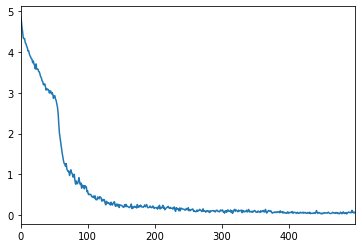

In [75]:
training_history["train_loss"].plot()

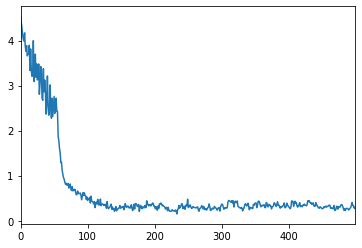

In [76]:
training_history["valid_loss"].plot()

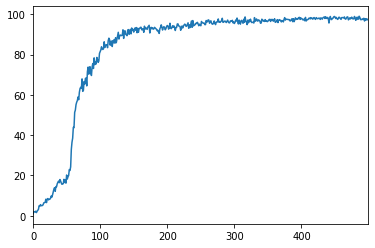

In [77]:
training_history["train_accuracy"].plot()

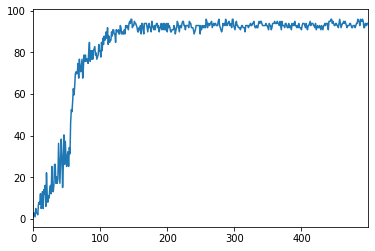

In [78]:
training_history["valid_accuracy"].plot()

In [79]:
all_pred = []
model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        torch_utils.clear_cuda()
        data = (data[0].to(device), data[1].to(device))
        y_pred = model(data).cpu()
        all_pred.append(torch.exp(y_pred))

In [80]:
df = pd.DataFrame(torch.cat(all_pred).numpy(), columns=le.classes_)

In [81]:
df.insert(0, "id", raw_test.id)
df.to_csv("torch_Submission.csv", index=False)

In [82]:
df.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.248743e-15,9.810202e-18,4.599580e-18,1.010958e-07,4.172064e-20,1.004897e-18,2.090520e-12,5.928289e-15,3.789376e-18,...,1.149523e-22,1.752809e-12,2.024685e-14,6.078964e-19,2.279168e-15,2.300145e-14,1.363965e-20,2.493423e-18,3.546188e-22,2.119055e-20
1,7,3.518905e-19,3.201246e-22,1.858941e-10,7.723427e-11,2.887956e-26,8.376755e-17,3.082452e-14,4.098586e-20,5.426534e-20,...,1.471518e-24,2.557486e-17,1.382564e-16,3.582674e-19,1.217389e-16,2.601203e-16,3.923697e-16,3.652019e-08,1.253739e-10,9.649373e-12
2,9,1.145346e-18,1.000000e+00,1.012437e-14,1.022495e-19,5.602308e-08,4.328240e-10,8.720607e-20,1.814246e-20,8.132862e-15,...,2.650399e-19,1.028219e-23,3.179655e-22,3.656958e-21,2.774431e-32,5.015776e-20,4.891713e-13,5.080368e-33,9.073593e-22,1.505692e-10
3,12,3.132703e-13,6.637863e-07,2.315737e-10,7.062288e-15,5.052179e-15,7.254198e-12,3.359301e-11,8.988323e-12,1.460755e-09,...,6.011214e-19,9.509936e-25,6.994370e-13,2.615978e-14,6.189193e-20,2.133502e-11,2.741445e-01,3.577809e-21,7.954836e-15,1.177624e-05
4,13,5.819731e-21,1.196014e-20,2.644065e-21,3.896793e-21,7.613541e-26,2.503133e-27,4.728310e-19,3.203161e-24,7.173682e-11,...,3.410424e-16,7.022825e-37,1.053906e-12,1.080892e-21,2.446107e-13,1.045349e-12,2.081169e-06,2.840028e-18,2.549460e-13,3.253340e-18
